In [1]:
# import pandas as pd

# url = 'https://fbref.com/en/players/aeca7743/scout/365_m1/Jackson-Tchatchoua-Scouting-Report'
# df = pd.read_html(url, attrs={"id": "scout_full_FB"})[0]

# df = df.dropna(how='all')

# df.columns = df.iloc[0]  
# df = df.drop(df.index[0])

# if df.columns[0] in ["Unnamed: 0", None]:
#     df = df.drop(columns=df.columns[0])

# df = df.reset_index(drop=True)

# # Save cleaned file
# df.to_excel("testing.xlsx", index=False)

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.5/donuts_dark/donut_Jackson_Tchatchoua.png


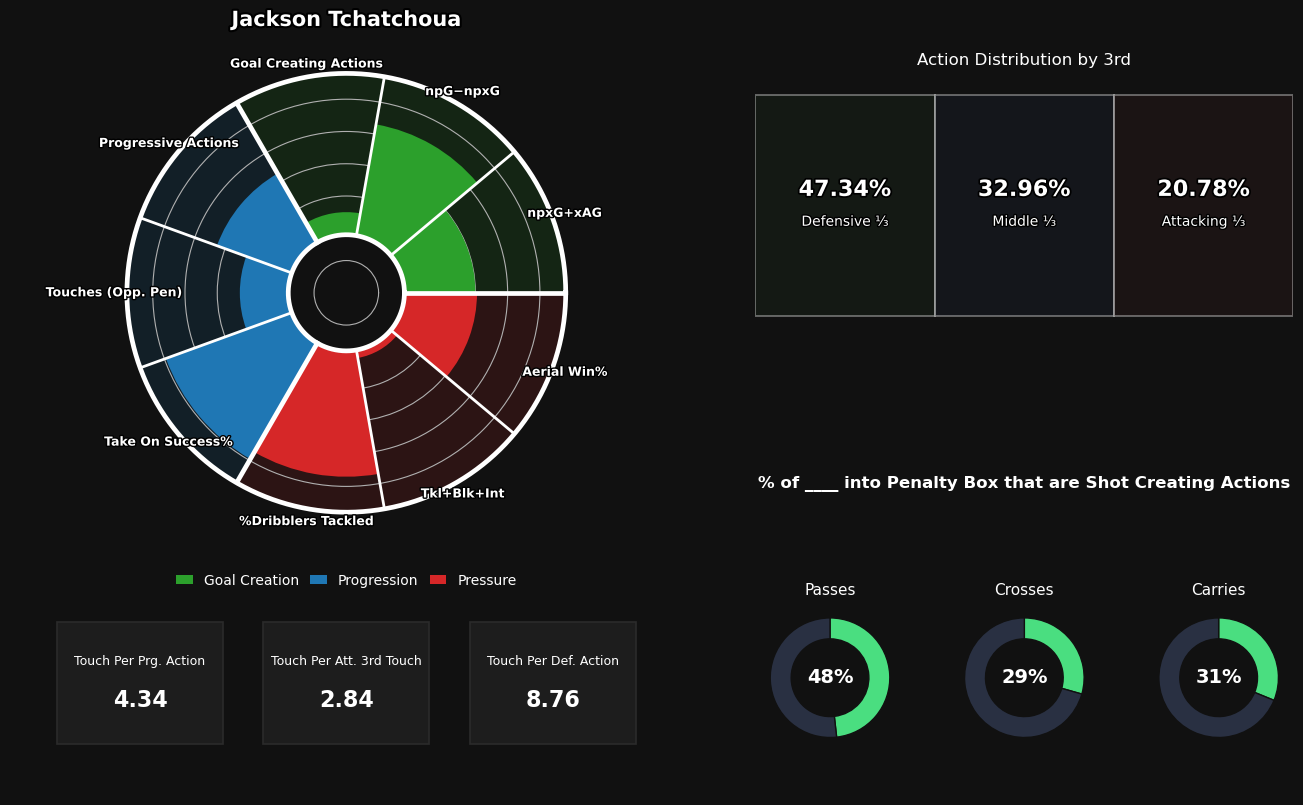

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.5/donuts_dark/donut_Ki-Jana_Hoever.png


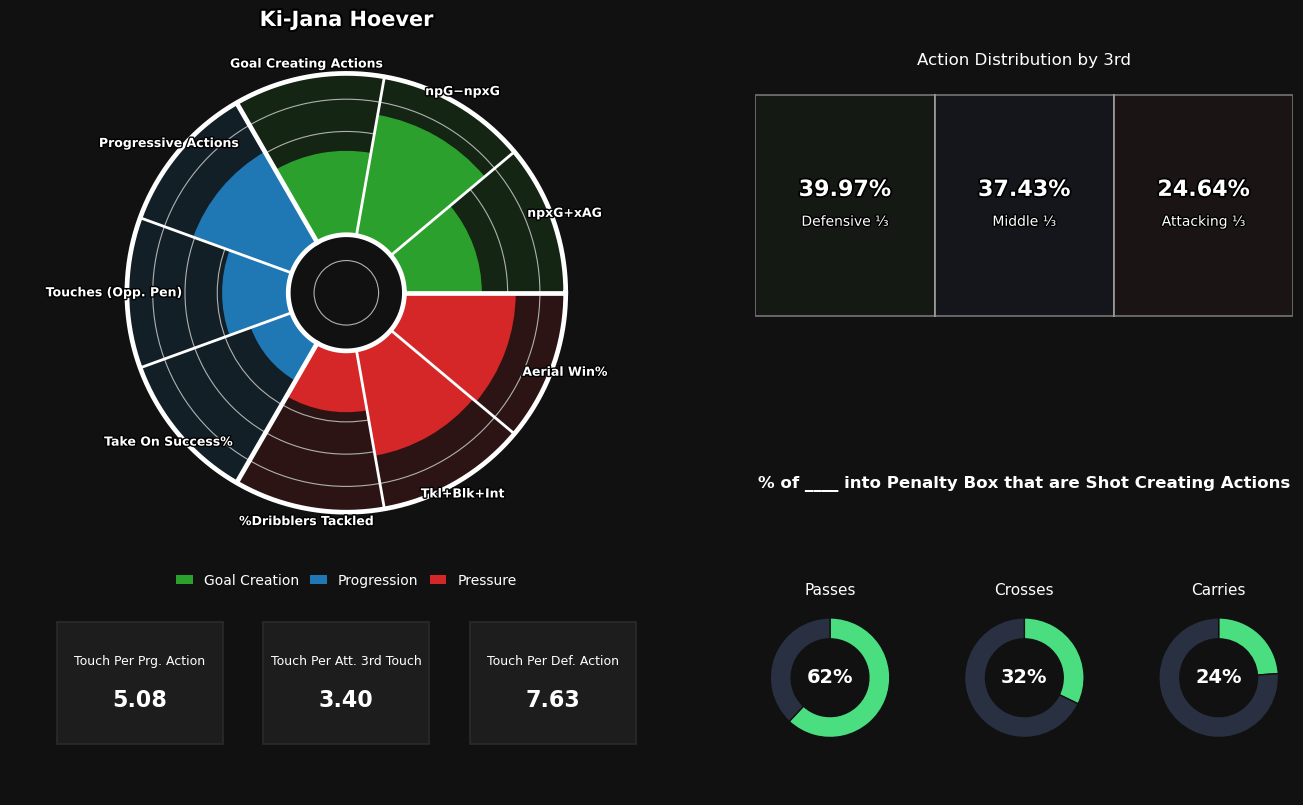

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.5/donuts_dark/donut_Hugo_Bueno.png


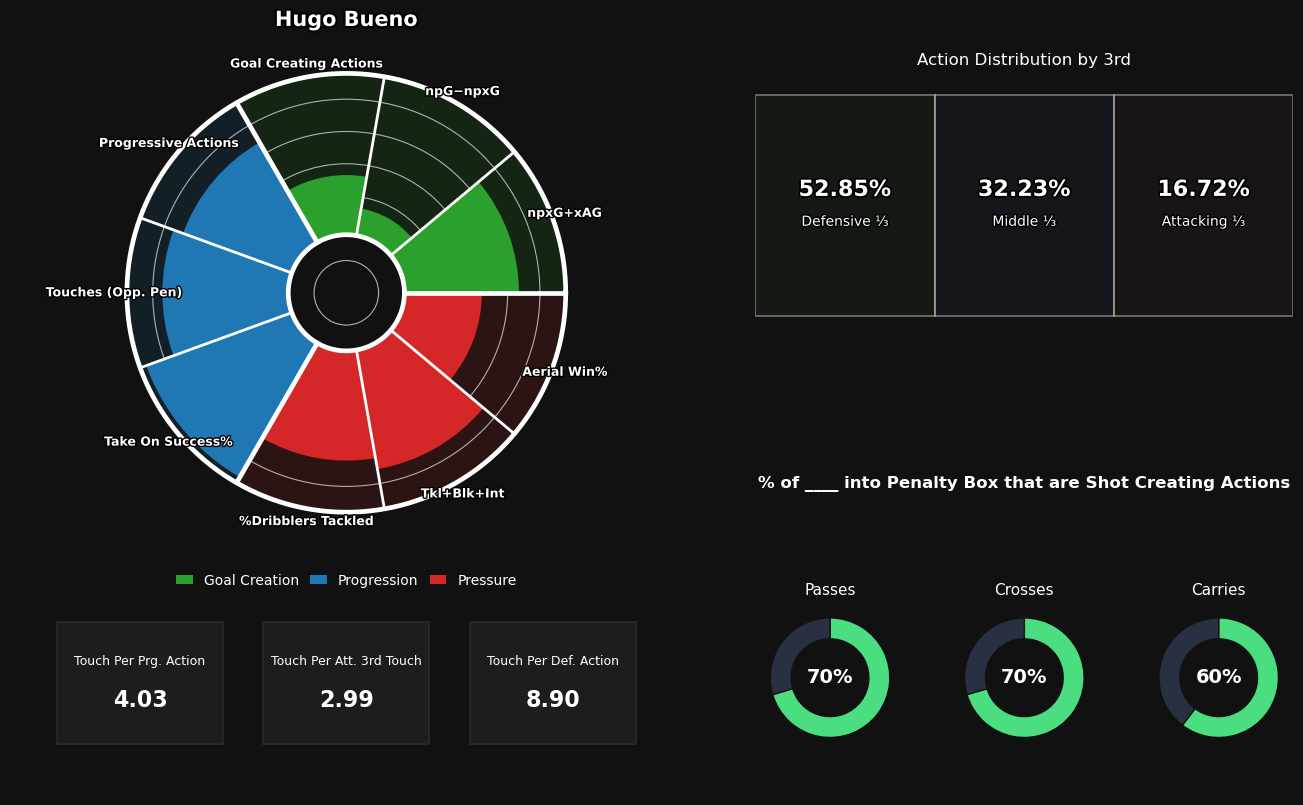

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.5/donuts_dark/donut_David_Møller_Wolfe.png


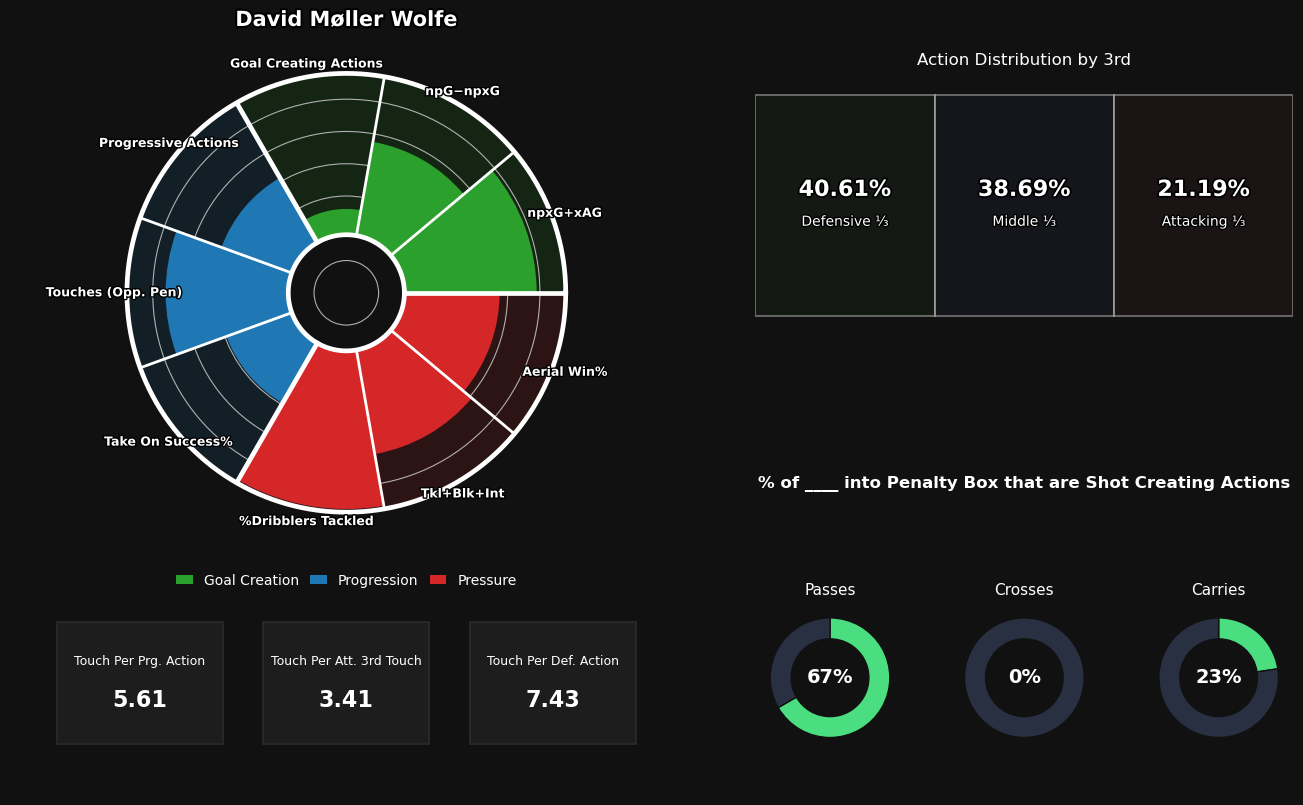

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.5/donuts_dark/donut_Rodrigo_Gomes.png


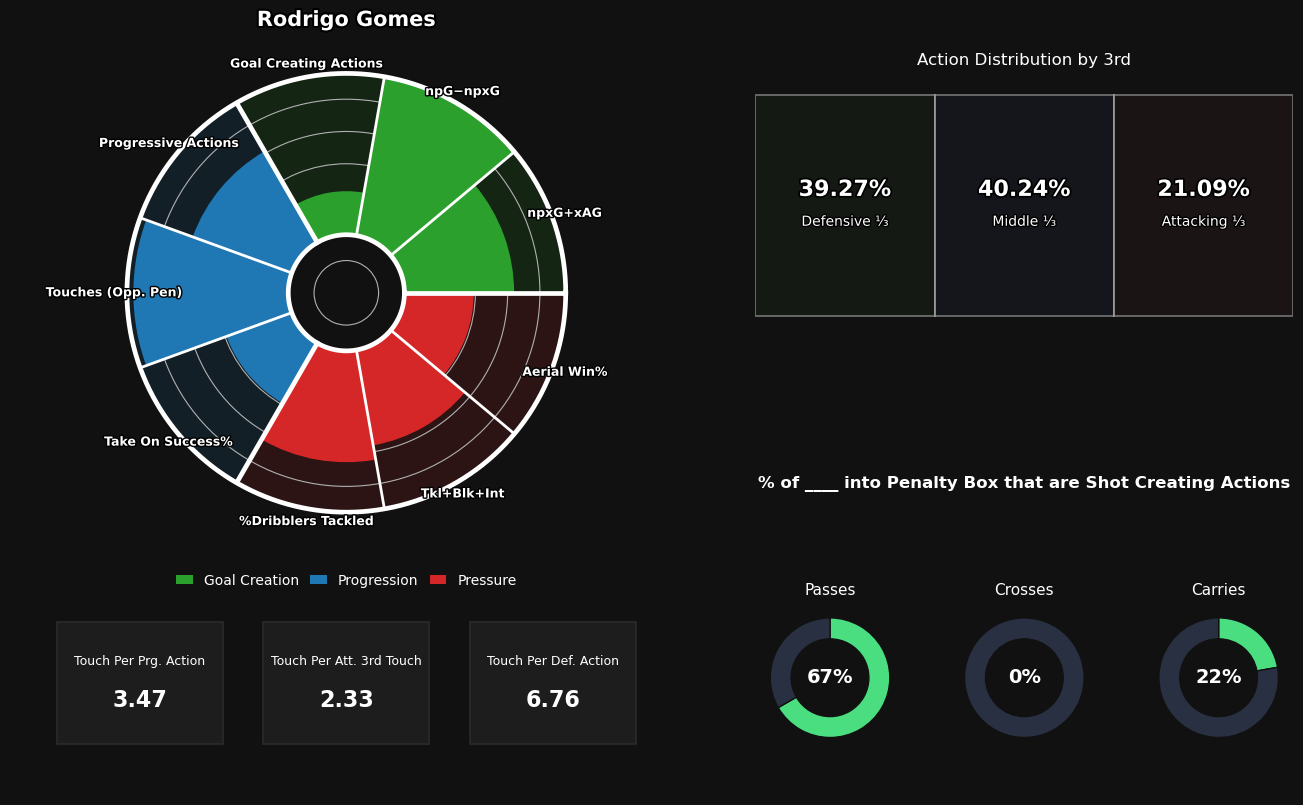

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from pathlib import Path

FILE = "tchatchoua.xlsx"        
SHEET = 0                      
OUTPUT_DIR = Path("donuts_dark")
SHOW_FIGS = True                 
PRINT_SAVES = True
TITLE_PREFIX = ""       

FIG_BG = AX_BG = "#111111"
GOAL_COLOR = "#2ca02c"         
PROG_COLOR = "#1f77b4"        
PRES_COLOR = "#d62728"  
SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.4

TILE_BG = "#1d1d1d"
TILE_EDGE = "#2b2b2b"
TILE_TEXT = "white"
TILE_VALUE = "white"

TITLE_FONTSIZE = 15
LABEL_FONTSIZE = 9
TILE_LABEL_FONTSIZE = 9
TILE_VALUE_FONTSIZE = 16

FIGSIZE = (13.8, 8.2) 
INNER_RADIUS = 0.36
ANNULUS_HEIGHT = 1.0

df = pd.read_excel(FILE, sheet_name=SHEET)

goal_creation = ["npxG+xAG", "npG-npxG", "GCA"]
progression   = ["PrgA", "TAP", "STO%"]
pressure      = ["%DT", "TBI", "AW%"]
metrics_order = goal_creation + progression + pressure

display_names = {
    "npxG+xAG": "npxG+xAG",
    "npG-npxG": "npG−npxG",
    "GCA": "Goal Creating Actions",
    "PrgA": "Progressive Actions",
    "TAP": "Touches (Opp. Pen)",
    "STO%": "Take On Success%",
    "%DT": "%Dribblers Tackled",
    "TBI": "Tkl+Blk+Int",
    "AW%": "Aerial Win%"
}

tiles = ["To/PrgA", "To/A3To", "To/TIBC"]
tile_labels = {
    "To/PrgA": "Touch Per Prg. Action",
    "To/A3To": "Touch Per Att. 3rd Touch",
    "To/TIBC": "Touch Per Def. Action"
}

third_cols = ["D3AR", "M3AR", "A3R"]
third_labels = ["Defensive ⅓", "Middle ⅓", "Attacking ⅓"]

donut_cols = [
    ("PPA/SCA",  "Passes"),
    ("CrPA/SCA", "Crosses"),
    ("CaPA/SCA", "Carries"),
]

OUTPUT_DIR.mkdir(exist_ok=True)

for col in metrics_order + tiles + ["Player"] + third_cols + [k for k,_ in donut_cols]:
    if col not in df.columns:
        print(f"WARNING: Column '{col}' not found. It will be treated as NaN/0.")

def metric_color(m):
    if m in goal_creation:
        return GOAL_COLOR
    if m in progression:
        return PROG_COLOR
    return PRES_COLOR

def safe_ratio(val):
    """Coerce to float in [0,1]; NaN→0; if 0..100 passed, rescale to 0..1."""
    try:
        x = float(val)
    except Exception:
        return 0.0
    if np.isnan(x):
        return 0.0
    if x > 1.0:
        x = x / 100.0
    return float(np.clip(x, 0.0, 1.0))

def draw_thirds_pitch(ax, d_share, m_share, a_share):
    """Horizontal thirds pitch (Def→Mid→Att) with big percentages."""
    ax.set_facecolor(FIG_BG)
    ax.axis("off")

    thirds_x = [0.0, 1/3, 2/3, 1.0]
    y0, y1 = 0.10, 0.92

    fills = [("#1a2a1a", 0.35), ("#1a2130", 0.35), ("#301a1a", 0.35)]
    labels = third_labels
    shares = [safe_ratio(d_share), safe_ratio(m_share), safe_ratio(a_share)]

    for i in range(3):
        x0, x1 = thirds_x[i], thirds_x[i+1]
        rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                             transform=ax.transAxes,
                             facecolor=fills[i][0], alpha=fills[i][1],
                             edgecolor="white", linewidth=1.4)
        ax.add_patch(rect)

        cx = (x0 + x1) / 2
        cy = (y0 + y1) / 2 + 0.06

        pct_text = ax.text(
            cx, cy, f"{shares[i]*100:.2f}%",
            transform=ax.transAxes, ha="center", va="center",
            fontsize=16, fontweight="bold", color="white", zorder=10
        )
        pct_text.set_path_effects([
            path_effects.Stroke(linewidth=2.5, foreground="black"),
            path_effects.Normal()
        ])

        lbl_text = ax.text(
            cx, cy - 0.12, labels[i],
            transform=ax.transAxes, ha="center", va="center",
            fontsize=10, color="white"
        )
        lbl_text.set_path_effects([
            path_effects.Stroke(linewidth=2.0, foreground="black"),
            path_effects.Normal()
        ])

def donut(ax, share, title, label_inside=True):
    ax.set_facecolor(AX_BG)
    s = safe_ratio(share)
    ax.pie(
        [s, 1 - s],
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.35, edgecolor=FIG_BG),
        colors=["#4ade80", "#293042"],
    )
    if label_inside:
        ax.text(0, 0, f"{s*100:.0f}%", ha="center", va="center",
                color="white", fontsize=14, fontweight="bold")
    ax.set_title(title, color="white", fontsize=11, pad=6)

n_metrics = len(metrics_order) 
angles = np.linspace(0, 2*np.pi, n_metrics, endpoint=False)
width  = 2*np.pi / n_metrics
theta_circle = np.linspace(0, 2*np.pi, 720)

idx_goal_end = len(goal_creation)
idx_prog_end = len(goal_creation) + len(progression)
wedge_colors = [metric_color(m) for m in metrics_order]

players = [str(p).strip() for p in df["Player"].astype(str).unique()]

for name in players:
    row = df.loc[df["Player"].astype(str) == name]
    if row.empty:
        continue

    vals_pct = []
    for m in metrics_order:
        v = pd.to_numeric(row.iloc[0].get(m, np.nan), errors='coerce')
        v = 0.0 if pd.isna(v) else float(v)
        v = np.clip(v, 0.0, 100.0)
        vals_pct.append(v/100.0)
    vals_pct = np.array(vals_pct, dtype=float)

    tile_vals = {}
    for t in tiles:
        val = row.iloc[0].get(t, np.nan)
        if pd.isna(val):
            tile_vals[t] = "—"
        else:
            try:
                fval = float(val)
                if abs(fval - round(fval)) < 1e-9 and abs(fval) < 1e6:
                    tile_vals[t] = f"{int(round(fval))}"
                else:
                    tile_vals[t] = f"{fval:.2f}"
            except:
                tile_vals[t] = str(val)

    d3 = safe_ratio(row.iloc[0].get("D3AR", np.nan))
    m3 = safe_ratio(row.iloc[0].get("M3AR", np.nan))
    a3 = safe_ratio(row.iloc[0].get("A3R",  np.nan))
    donut_shares = [safe_ratio(row.iloc[0].get(col, np.nan)) for col,_ in donut_cols]

    fig = plt.figure(figsize=FIGSIZE)
    fig.patch.set_facecolor(FIG_BG)

    outer = fig.add_gridspec(
        nrows=1, ncols=2,
        width_ratios=[1.25, 1.00],  
        wspace=0.12
    )

    left = outer[0, 0].subgridspec(
        nrows=5, ncols=1,
        height_ratios=[9.0, 0.8, 1.2, 3.2, 0.6], 
        hspace=0.0
    )
    ax_polar  = fig.add_subplot(left[0], projection="polar")
    ax_sp0    = fig.add_subplot(left[1])
    ax_legend = fig.add_subplot(left[2])
    ax_tiles  = fig.add_subplot(left[3])
    ax_sp1    = fig.add_subplot(left[4])

    right = outer[0, 1].subgridspec(
        nrows=4, ncols=1,
        height_ratios=[4.6, 0.7, 1.4, 4.0],
        hspace=0.2
    )
    ax_thirds      = fig.add_subplot(right[0])
    ax_sp2         = fig.add_subplot(right[1])
    ax_donut_title = fig.add_subplot(right[2])
    gs_donuts      = right[3].subgridspec(1, 3, wspace=0.30)

    for sp in (ax_sp0, ax_sp1, ax_sp2):
        sp.axis("off")
        sp.set_facecolor(FIG_BG)

    ax = ax_polar
    ax.set_facecolor(AX_BG)
    ax.set_ylim(0, INNER_RADIUS + ANNULUS_HEIGHT)
    inner_overlay = INNER_RADIUS
    outer_radius  = INNER_RADIUS + ANNULUS_HEIGHT

    ax.bar(
        angles, np.full(n_metrics, ANNULUS_HEIGHT),
        width=width, bottom=inner_overlay, align='edge',
        color=[metric_color(m) for m in metrics_order],
        alpha=0.14, zorder=1, edgecolor=None
    )

    ax.bar(
        angles, vals_pct * ANNULUS_HEIGHT,
        width=width, bottom=inner_overlay, align='edge',
        color=wedge_colors, zorder=2, edgecolor=None
    )
    for ang in angles:
        ax.plot([ang, ang], [inner_overlay, outer_radius],
                linewidth=SEP_THIN, color=SEPARATOR_COLOR, alpha=1.0, zorder=3)
    for b_idx in [0, idx_goal_end, idx_prog_end]:
        ax.plot([angles[b_idx], angles[b_idx]],
                [inner_overlay, outer_radius],
                linewidth=SEP_THICK, color=SEPARATOR_COLOR, alpha=1.0, zorder=4)
    theta_circle = np.linspace(0, 2*np.pi, 720)
    ax.plot(theta_circle, np.full_like(theta_circle, outer_radius),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=5, clip_on=False)
    ax.plot(theta_circle, np.full_like(theta_circle, inner_overlay),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=6, clip_on=False)

    centers = angles + width/2
    for ang, m in zip(centers, metrics_order):
        label = display_names.get(m, m)
        txt = ax.text(
            ang, INNER_RADIUS + ANNULUS_HEIGHT + 0.08, label,
            ha='center', va='center', fontsize=LABEL_FONTSIZE,
            fontweight='bold', color='white', zorder=7
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])

    title_text = ax.set_title(
        f"{TITLE_PREFIX}{name}",
        va='bottom', y=1.08,
        fontsize=TITLE_FONTSIZE, fontweight='bold', color='white'
    )
    title_text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])

    ax.set_xticks([]); ax.set_yticklabels([]); ax.set_thetagrids([])

    ax_legend.set_facecolor(FIG_BG)
    ax_legend.axis("off")
    legend_handles = [
        Patch(facecolor=GOAL_COLOR, label="Goal Creation"),
        Patch(facecolor=PROG_COLOR, label="Progression"),
        Patch(facecolor=PRES_COLOR, label="Pressure"),
    ]
    leg = ax_legend.legend(
        handles=legend_handles,
        loc='center', ncol=3, frameon=True,
        borderpad=0.6, handlelength=1.2, columnspacing=0.8, labelspacing=0.6
    )
    plt.setp(leg.get_texts(), color='white')
    leg.get_frame().set_facecolor(FIG_BG)
    leg.get_frame().set_edgecolor("none")

    ax_tiles.set_facecolor(FIG_BG)
    ax_tiles.axis("off")
    pad_x = 0.07
    gap = 0.06
    tile_w = (1.0 - 2*pad_x - 2*gap) / 3.0
    tile_h = 0.78
    y0 = 0.14
    x_positions = [pad_x + i*(tile_w + gap) for i in range(3)]

    for i, key in enumerate(tiles):
        x0 = x_positions[i]
        rect = plt.Rectangle(
            (x0, y0), tile_w, tile_h,
            transform=ax_tiles.transAxes, facecolor=TILE_BG,
            edgecolor=TILE_EDGE, linewidth=1.2
        )
        ax_tiles.add_patch(rect)
        ax_tiles.text(
            x0 + tile_w/2, y0 + tile_h*0.68,
            tile_labels.get(key, key),
            ha='center', va='center',
            fontsize=TILE_LABEL_FONTSIZE, color=TILE_TEXT
        )
        ax_tiles.text(
            x0 + tile_w/2, y0 + tile_h*0.36,
            tile_vals.get(key, "—"),
            ha='center', va='center',
            fontsize=TILE_VALUE_FONTSIZE, color=TILE_VALUE, fontweight='bold'
        )

    draw_thirds_pitch(ax_thirds, d3, m3, a3)
    ax_thirds.set_title("Action Distribution by 3rd",
                        color="white", fontsize=12, pad=6)

    ax_donut_title.set_facecolor(FIG_BG)
    ax_donut_title.axis("off")
    ax_donut_title.text(
        0.5, 0.55,
        "% of ____ into Penalty Box that are Shot Creating Actions",
        ha='center', va='center', color='white', fontsize=12, fontweight='bold'
    )

    donut_axes = [fig.add_subplot(gs_donuts[0, i]) for i in range(3)]
    for axd in donut_axes:
        axd.set_facecolor(FIG_BG)
    for axd, (col, ttl), share in zip(donut_axes, donut_cols, donut_shares):
        donut(axd, share, ttl, label_inside=True)

    plt.subplots_adjust(left=0.05, right=0.98, top=0.94, bottom=0.06)
    safe = name.replace("/", "_").replace("\\", "_").replace(" ", "_")
    out_path = OUTPUT_DIR / f"donut_{safe}.png"
    plt.savefig(out_path, dpi=220, facecolor=FIG_BG, bbox_inches="tight", pad_inches=0.28)
    if PRINT_SAVES:
        print(f"Saved: {out_path.resolve()}")
    if SHOW_FIGS:
        plt.show()
    else:
        plt.close(fig)


Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.5/donuts_dark/donut_scatter_group.png


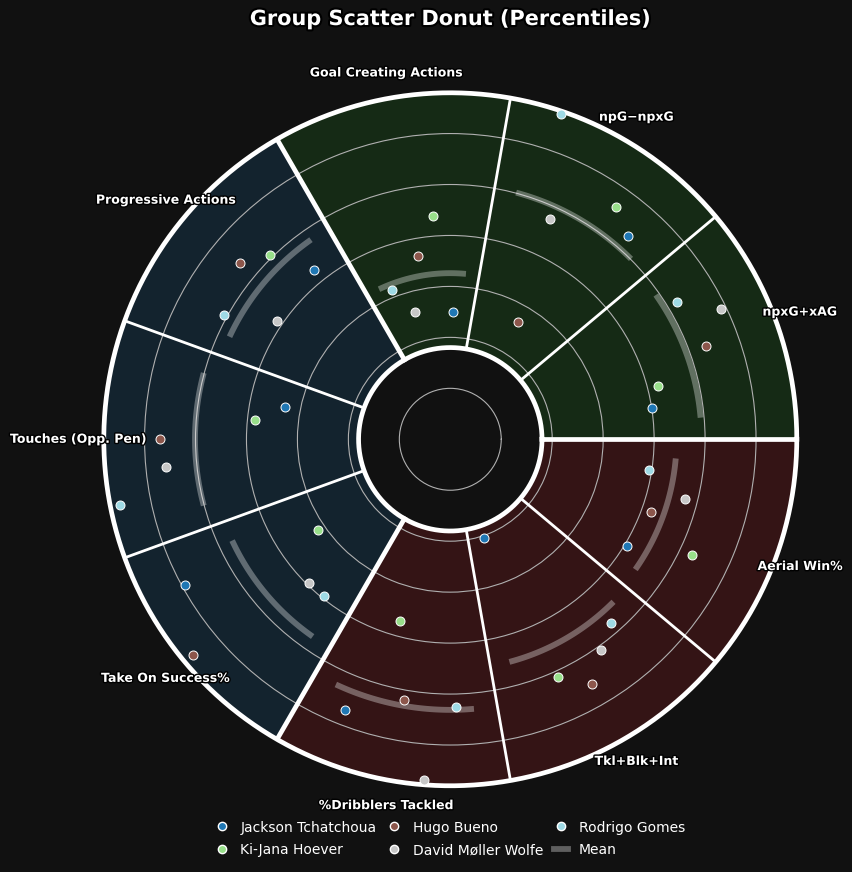

In [2]:
import matplotlib as mpl

players_all = [str(p).strip() for p in df["Player"].astype(str).unique()]
vals_mat = []
valid_players = []
for p in players_all:
    row = df.loc[df["Player"].astype(str) == p]
    if row.empty:
        continue
    row_vals = []
    for m in metrics_order:
        v = pd.to_numeric(row.iloc[0].get(m, np.nan), errors='coerce')
        v = 0.0 if pd.isna(v) else float(np.clip(v, 0.0, 100.0)) / 100.0
        row_vals.append(v)
    if np.all(np.isnan(row_vals)):
        continue
    vals_mat.append(row_vals)
    valid_players.append(p)

if len(valid_players) == 0:
    print("No players with data to build group scatter donut.")
else:
    group_vals = np.array(vals_mat, dtype=float) 
    means = np.nanmean(group_vals, axis=0)
    FIGSIZE_GROUP = (9.0, 9.0)
    fig = plt.figure(figsize=FIGSIZE_GROUP)
    fig.patch.set_facecolor(FIG_BG)
    axg = plt.subplot(111, projection="polar")
    axg.set_facecolor(AX_BG)
    axg.set_ylim(0, INNER_RADIUS + ANNULUS_HEIGHT)

    inner_overlay = INNER_RADIUS
    outer_radius  = INNER_RADIUS + ANNULUS_HEIGHT
    theta_circle  = np.linspace(0, 2*np.pi, 900)
    centers       = angles + width/2

    axg.bar(
        angles, np.full(len(metrics_order), ANNULUS_HEIGHT),
        width=width, bottom=inner_overlay, align='edge',
        color=[metric_color(m) for m in metrics_order],
        alpha=0.18, zorder=1, edgecolor=None
    )

    for ang in angles:
        axg.plot([ang, ang], [inner_overlay, outer_radius],
                 linewidth=SEP_THIN, color=SEPARATOR_COLOR, alpha=1.0, zorder=3)

    idx_goal_end = len(goal_creation)
    idx_prog_end = len(goal_creation) + len(progression)
    for b_idx in [0, idx_goal_end, idx_prog_end]:
        axg.plot([angles[b_idx], angles[b_idx]],
                 [inner_overlay, outer_radius],
                 linewidth=SEP_THICK, color=SEPARATOR_COLOR, alpha=1.0, zorder=4)

    axg.plot(theta_circle, np.full_like(theta_circle, outer_radius),
             color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=5, clip_on=False)
    axg.plot(theta_circle, np.full_like(theta_circle, inner_overlay),
             color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=5, clip_on=False)

    mean_half = width * 0.36
    for i, mu in enumerate(means):
        r_mu = inner_overlay + float(mu) * ANNULUS_HEIGHT
        thetas = np.linspace(centers[i] - mean_half, centers[i] + mean_half, 80)
        axg.plot(thetas, np.full_like(thetas, r_mu),
                 color="white", linewidth=4.2, alpha=0.33, zorder=6, clip_on=False)

    try:
        cmap = mpl.colormaps.get_cmap('tab20').resampled(max(1, len(valid_players)))
    except Exception:
        cmap = plt.cm.get_cmap('tab20', max(1, len(valid_players)))
    player_colors = {p: cmap(i) for i, p in enumerate(valid_players)}

    nP = len(valid_players)
    ang_offsets = np.linspace(-width*0.28, width*0.28, nP) if nP > 1 else np.array([0.0])

    DOT_SIZE = 42
    eps = 0.006  
    for j, p in enumerate(valid_players):
        vals = group_vals[j] 
        thetas = centers + ang_offsets[j]
        rs = inner_overlay + vals * ANNULUS_HEIGHT
        rs = np.clip(rs, inner_overlay + eps, outer_radius - eps)
        axg.scatter(thetas, rs, s=DOT_SIZE, color=player_colors[p],
                    edgecolor="white", linewidth=0.7, zorder=7.5, label=p, clip_on=False)

    for ang, m in zip(centers, metrics_order):
        lab = display_names.get(m, m)
        txt = axg.text(
            ang, INNER_RADIUS + ANNULUS_HEIGHT + 0.10, lab,
            ha='center', va='center', fontsize=LABEL_FONTSIZE,
            fontweight='bold', color='white', zorder=8
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])

    title_text = axg.set_title(
        "Group Scatter Donut (Percentiles)",
        va='bottom', y=1.08,
        fontsize=TITLE_FONTSIZE, fontweight='bold', color='white'
    )
    title_text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])

    ncols = min(6, max(3, int(np.ceil(nP / 3))))
    handles = [
        Line2D([0], [0], marker='o', linestyle='', markersize=6,
               markerfacecolor=player_colors[p], markeredgecolor='white', label=p)
        for p in valid_players
    ]
    mean_handle = Line2D([0], [0], color="white", lw=4.2, alpha=0.33, label="Mean")
    handles.append(mean_handle)
    labels = valid_players + ["Mean"]

    leg = axg.legend(
        handles, labels, loc='lower center',
        bbox_to_anchor=(0.5, -0.12),
        ncol=ncols, frameon=True, handlelength=1.0,
        columnspacing=0.8, labelspacing=0.6
    )
    plt.setp(leg.get_texts(), color='white')
    leg.get_frame().set_facecolor(FIG_BG)
    leg.get_frame().set_edgecolor("none")

    axg.set_xticks([]); axg.set_yticklabels([]); axg.set_thetagrids([])

    out_path_grp = OUTPUT_DIR / "donut_scatter_group.png"
    plt.savefig(out_path_grp, dpi=230, bbox_inches="tight", facecolor=FIG_BG, pad_inches=0.28)
    if PRINT_SAVES:
        print(f"Saved: {out_path_grp.resolve()}")
    if SHOW_FIGS:
        plt.show()
    else:
        plt.close(fig)
